# Inhibitor effect on clusters

In [1]:
# If problems installing slingshot
# sudo apt-get update
# sudo apt-get install libglu1-mesa-dev 
# sudo apt-get install freeglut3-dev
# sudo apt-get install mesa-common-dev
# then
# install.packages("rgl")
# BiocManager::install("slingshot")
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(reshape2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




In [2]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/jovyan/my-conda-envs/R4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] reshape2_1.4.4     cowplot_1.0.0      pheatmap_1.0.12    ggplot2_3.3.1     
[5] destiny_3.2.0      RColorBrewer_1.1-2 dplyr_1.0.0       

loaded via a namespace (and not attached):
 [1] bitops_1.0-6                matrixStats_0.56.0         
 [3] xts_0.12-0                  GenomeInfoDb_1.24.0        

# Process with Seurat from raw

In [3]:
metadata = read.csv('figures_organoid_confInhibitors/Donor19/barcode_metadata.csv', stringsAsFactors = F)
head(metadata)

,index,Days,Donor,Donor_demu,G2M_score,Inhibition,S_score,Sample,Treatment,batch,⋯,n_genes,percent_mito,phase,scrublet_cluster_score,scrublet_score,tp,zscore,clusters_noIn,clusters,clusters2
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<int>,⋯,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,WSSS_END8730455-GAGAGGTAGCGTTAGG,7.000,B019,B019,0.1686447,N/I,-0.1567363,WSSS_END8730455,E+P,0,⋯,3544,0.13286243,G2M,0.07532416,0.05078125,NaN,-0.5776906,Inter_PGRpos,inter,inter
2,WSSS_END8730359-ACGCACGAGATGTTAG,6.000,B019,B019,-0.2955429,N/I,-0.6394048,WSSS_END8730359,E+P,0,⋯,2728,0.10568083,G1,0.07502826,0.06170213,NaN,-0.4751039,Secretory,inter,inter
3,WSSS_END8729880-AACAACCCAAGATGTA,1.125,B019,B019,-0.2943309,N/I,-0.2198316,WSSS_END8729880,E,0,⋯,4295,0.08141119,G1,0.09210162,0.06371912,NaN,-0.4688600,KRT5_KRT13,KRT5_KRT13,KRT5_KRT13
4,WSSS_END8729881-TTGCGTCCAGCACACC,1.000,B019,B019,0.8935155,N/I,1.7203829,WSSS_END8729881,N/H,0,⋯,3477,0.18025091,S,0.14431239,0.17082534,NaN,0.1988736,proliferative,proliferative,proliferative
5,WSSS_END8730359-TCATTCATCACTGGGC,6.000,B019,B019,0.3130226,N/I,0.8051419,WSSS_END8730359,E+P,0,⋯,4146,0.09370229,S,0.10656934,0.10656934,NaN,0.4273416,proliferative,proliferative,proliferative
6,WSSS_END8729881-GGGTATTCATTCTTCA,1.000,B019,B019,0.2247102,N/I,1.2648440,WSSS_END8729881,N/H,0,⋯,2805,0.19018666,S,0.06996771,0.11432706,NaN,-1.1347998,proliferative,proliferative,proliferative


In [4]:
unique(metadata$Inhibition)

[1] "N/I"        "WNT-XAV939" "NOTCH-DBZ"

In [6]:
create_contingency_table = function(perturbed_cl, control_cl, perturbed, control){
    if(length(perturbed_cl) == 0 || length(control_cl) == 0){
        perturbed_cl = c(perturbed_cl, '1')
        control_cl = c(control_cl, '1')
        perturbed = c(perturbed, '1')
        control = c(control, '1')
    }
    m = matrix(c(length(perturbed_cl), length(control_cl), 
               length(perturbed),  length(control)), 
             ncol = 2, dimnames = list(c('I', 'C'), c('in_cl', 'total')) )
  return(m)  
}


enrichment = function(perturbed_cl, control_cl, perturbed, control){
  funtable = create_contingency_table(perturbed_cl, control_cl, perturbed, control)
  ft = fisher.test(funtable)
  pvalue = ft$p.value
  estimate = ft$estimate
  conf.int = ft$conf.int
  out = data.frame(pvalue= pvalue, odds.ratio = estimate, min_confint = conf.int[1], max_confint = conf.int[2],  stringsAsFactors = F)
  return(out)
}

test_cluster = function(cl){
    message(cl)
    results = list()
    for (I in inhibitors)
    for (tm in times){
        perturbed = subset(metadata, Inhibition == I & Days == tm)$index
        perturbed_cl = subset(metadata, Inhibition == I & Days == tm & clusters == cl)$index
        control = subset(metadata, Inhibition == 'N/I' & Days == tm)$index
        control_cl = subset(metadata, Inhibition == 'N/I' & Days == tm & clusters == cl)$index
        out = enrichment(perturbed_cl, control_cl, perturbed, control)
        out$inhibitor2 = I
        out$inhibitor = gsub('NOTCH-', '', I) %>% gsub('WNT-', '', .)
        out$id = paste0(out$inhibitor , ' day', tm)
        out$cell_type = cl
        results[[paste0(I, '_day', tm) ]] = out
        
    }
    df = melt(results, id.vars = colnames(results[[1]]))[, -9]
    df$pvalue_adj = p.adjust(df$pvalue)
    df$label = ifelse(df$pvalue_adj < 0.05, '*', '')
    df$label[ df$pvalue_adj < 0.01] = '**'
    df$label[ df$pvalue_adj < 0.001] = '***'
    
    y_max = max(df$max_confint[ ! is.infinite(df$max_confint) ] )
    y_max = log(y_max) + 0.7
    P = ggplot(df, aes(x=id, y=log(odds.ratio), fill = inhibitor, label = label) ) + 
       # scale_y_continuous(limits = log(c(min(df$min_confint[ ! is.infinite(df$min_confint) ]), max(df$max_confint[ ! is.infinite(df$max_confint) ] ) )) ) + 
        scale_y_continuous(limits = c(log(min(df$min_confint[ ! is.infinite(df$min_confint) ])), y_max) ) + 
        geom_bar(stat = 'identity') + 
        geom_point(show.legend = F) + 
        geom_errorbar(mapping = aes(ymin = log(min_confint), ymax = log(max_confint)), width=0.5, size=0.2) +
        geom_text(color = 'black', y = y_max*0.9, size = 6) +
        scale_fill_manual(values = c("#96b2e3",  "#e39696") ) +
        theme_bw(18) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1), 
                             panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
        ggtitle(cl) + xlab('') + ylab('odds ratio (log scale)\n N cells enrichment')
    P
    
    ggsave(filename = paste0('figures_organoid_confInhibitors/Donor19/barplot_inhibitorsenrichment_', cl, '.pdf') )
    return(P)
}

inter

Saving 6.67 x 6.67 in image

KRT5_KRT13

Saving 6.67 x 6.67 in image

proliferative

Saving 6.67 x 6.67 in image

inter_PGRneg

Saving 6.67 x 6.67 in image

pre_KRT5_KRT13

Saving 6.67 x 6.67 in image

ciliated

Saving 6.67 x 6.67 in image

KRT5_LRG6

Saving 6.67 x 6.67 in image



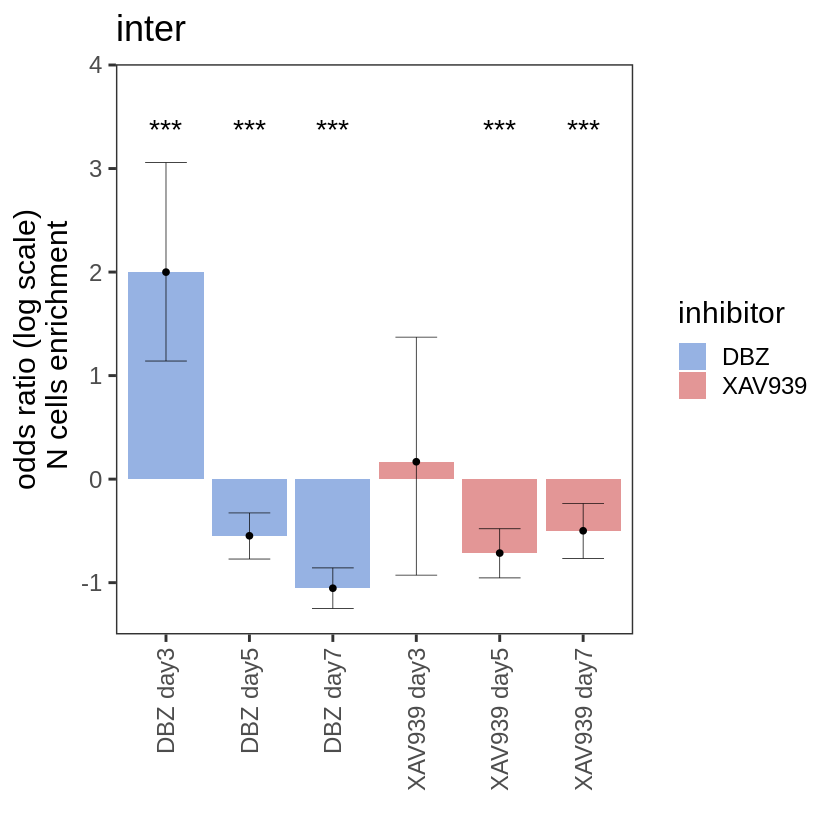

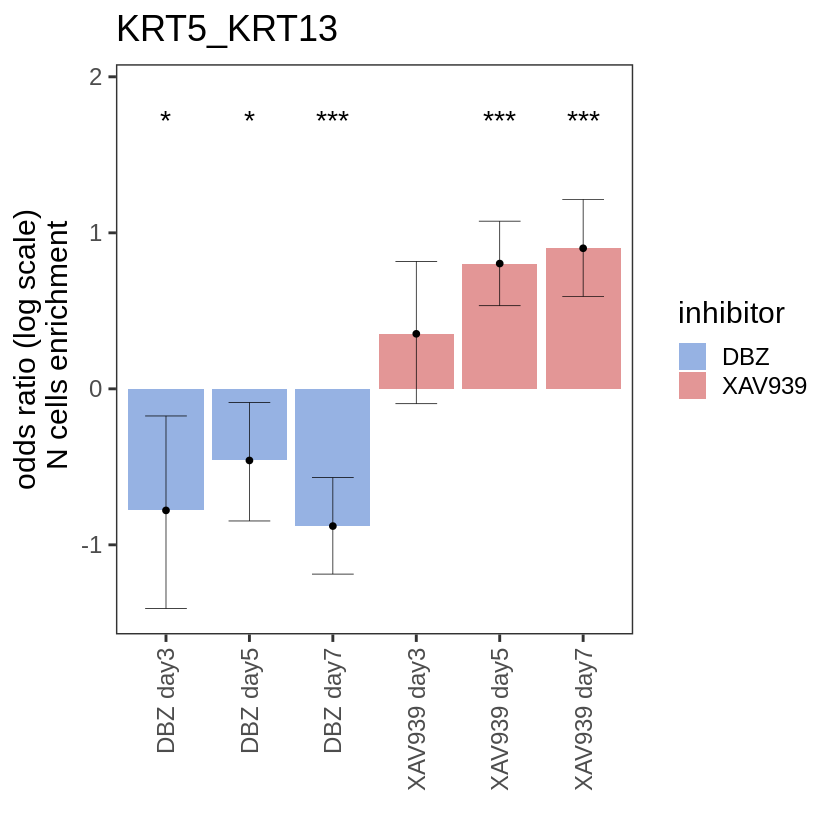

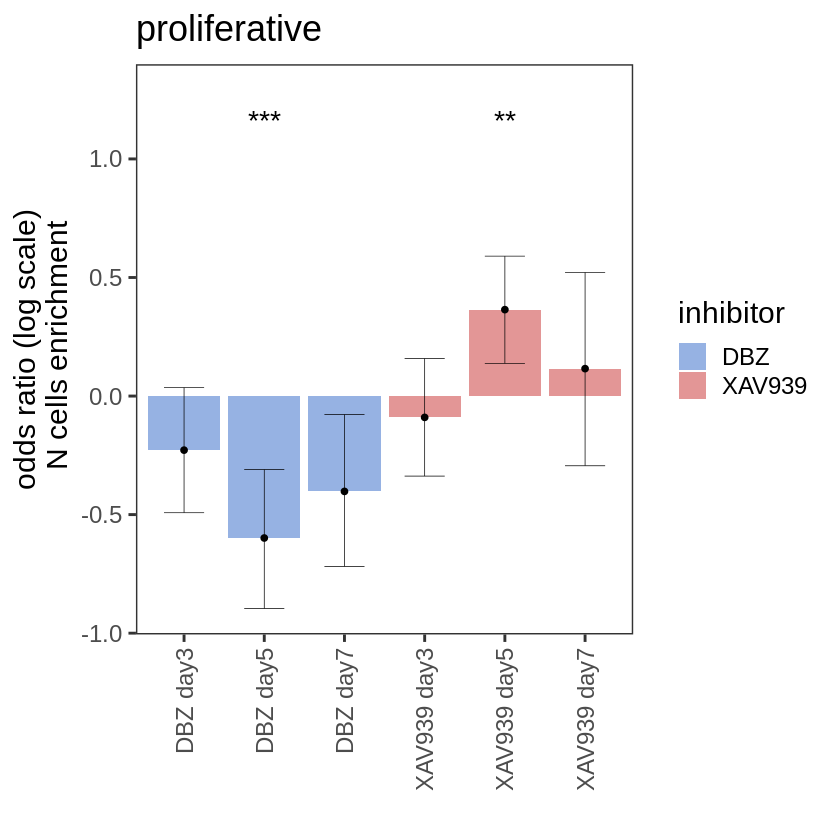

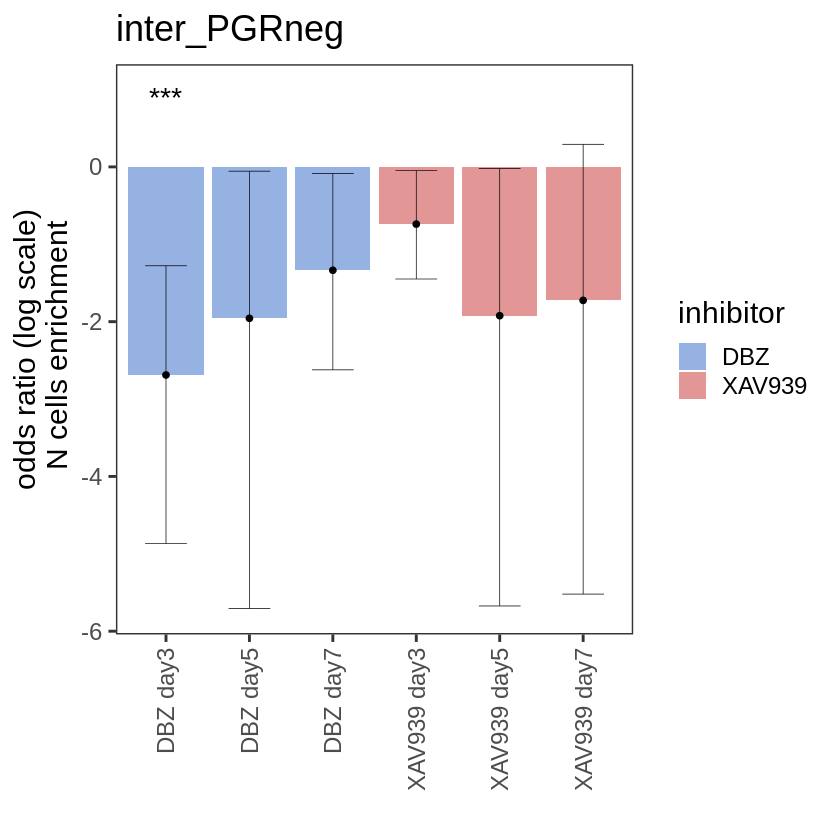

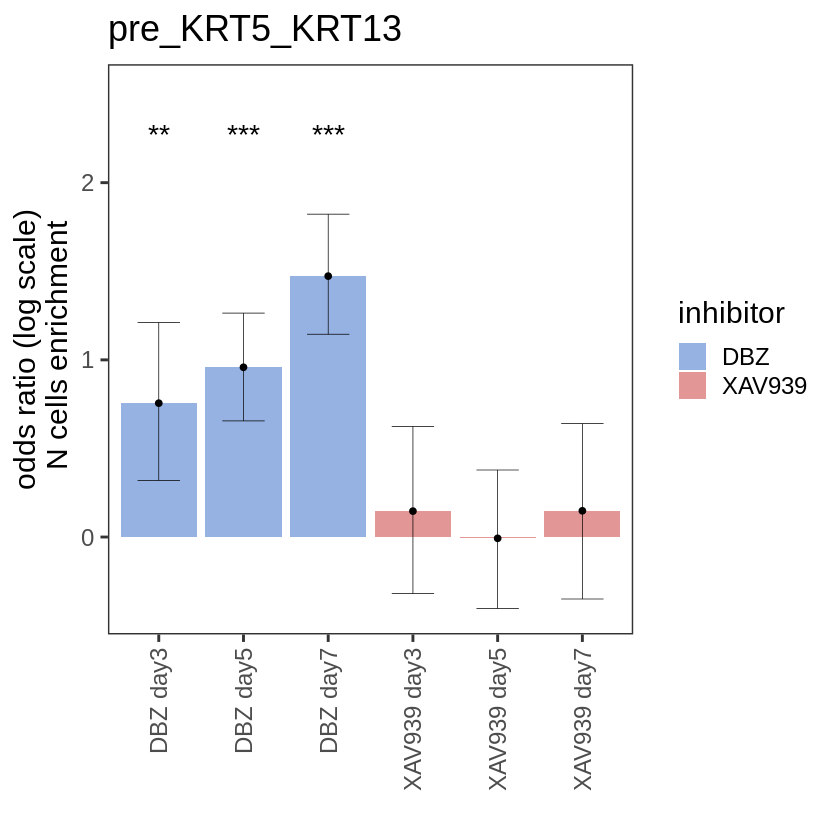

$inter

$KRT5_KRT13

$proliferative

$inter_PGRneg

$pre_KRT5_KRT13

$ciliated

$KRT5_LRG6


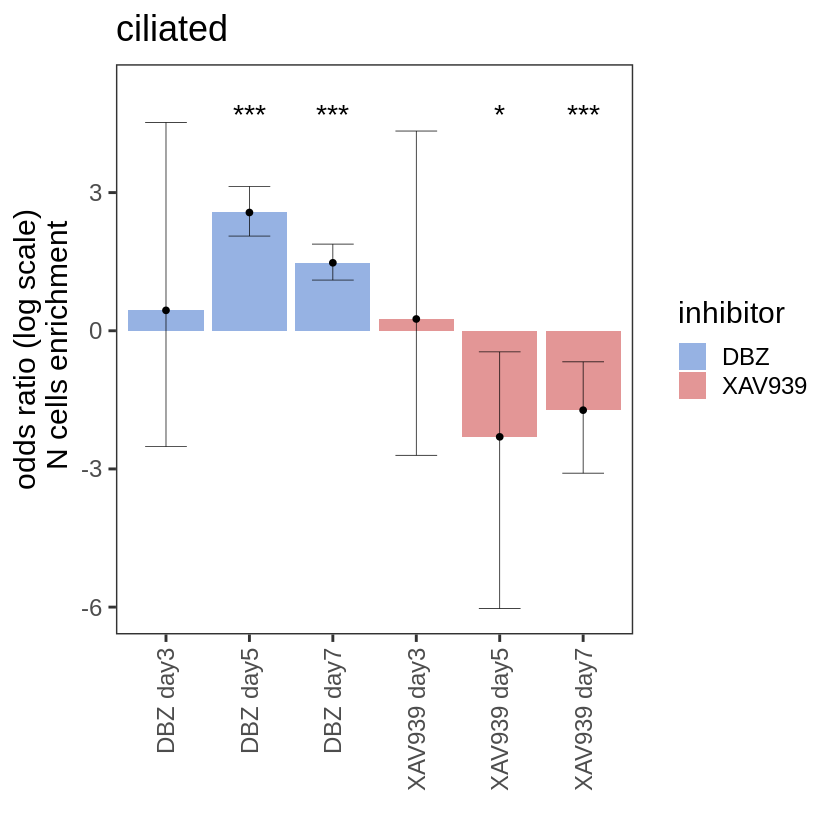

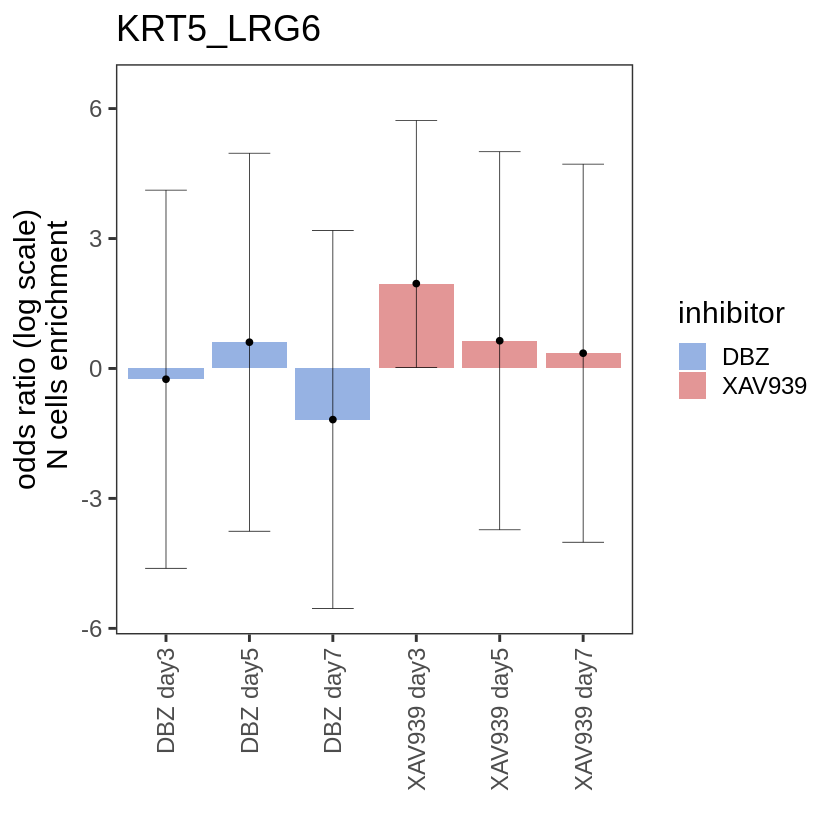

In [7]:
inhibitors = setdiff(metadata$Inhibition, 'N/I')
times = c(3, 5, 7)
R = list()
for (cl in unique(metadata$clusters))
    R[[cl]] = test_cluster(cl)
R